In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import binom

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [3]:
def run_sim(D,DClass,DContext,NClass,NContext):
    # build AM for each context
    AM = np.zeros((NContext,NClass,D),dtype=np.int8)
    seed = np.random.choice((-1,1),D).astype('int')
    for i in range(NContext):
        for j in range(NClass):
            flipIdx = np.random.permutation(D)[:DClass]
            flipBits = np.ones(D)
            flipBits[flipIdx] = -1
            AM[i,j,:] = seed*flipBits

    # build CM of context vectors 
    CM = np.zeros((NContext,D),dtype=np.int8)
    seed = np.random.choice((-1,1),D).astype('int')
    for i in range(NContext):
        flipIdx = np.random.permutation(D)[:DContext]
        flipBits = np.ones(D)
        flipBits[flipIdx] = -1
        CM[i,:] = seed*flipBits

    # calculate baseline margin within each AM
    baseMargin = 0
    for i in range(NContext):
        contextAM = AM[i]
        d = cdist(contextAM,contextAM,'hamming')
        baseMargin += np.mean(d[~np.eye(d.shape[0],dtype=bool)])/NContext

    # calculate margin with direct superposition
    directCorrect = 0
    directIncorrect = 0
    AMsuper = bipolarize(np.sum(AM,axis=0))
    for i in range(NContext):
        contextAM = AM[i]
        d = cdist(contextAM,AMsuper,'hamming')
        directCorrect += np.mean(np.diag(d))/NContext
        directIncorrect += np.mean(d[~np.eye(d.shape[0],dtype=bool)])/NContext
#     directMargin = directIncorrect - directCorrect
    directMargin = (directIncorrect - directCorrect)/(directIncorrect + directCorrect)

    # calculate random margin
    AMencoded = np.zeros(AM.shape,dtype=np.int8)
    for i in range(NContext):
        AMencoded[i] = AM[i]*CM[i]
    AMencodedSuper = bipolarize(np.sum(AMencoded,axis=0))
    encodedCorrect = 0
    encodedIncorrect = 0
    for i in range(NContext):
        contextAM = AMencoded[i]
        d = cdist(contextAM,AMencodedSuper,'hamming')
        encodedCorrect += np.mean(np.diag(d))/NContext
        encodedIncorrect += np.mean(d[~np.eye(d.shape[0],dtype=bool)])/NContext
#     encodedMargin  = encodedIncorrect - encodedCorrect
    encodedMargin  = (encodedIncorrect - encodedCorrect)/(encodedIncorrect + encodedCorrect)
    
    return [baseMargin,directCorrect,directIncorrect,directMargin,encodedCorrect,encodedIncorrect,encodedMargin]


In [4]:
def get_direct_correct(N,p):
    M = N-1
    return p*binom.cdf(M/2-1,M,p) + (1-p)*binom.cdf(M/2-1,M,(1-p))

def get_direct_incorrect(N,p):
    return p*binom.cdf(np.floor(N/2),N,p) + (1-p)*binom.cdf(np.floor(N/2),N,(1-p))

def get_encoded_incorrect(N,p):
    M = N-1
    p0 = 2*p*(1-p)
    q0 = 1-p0 # probability B is same
    r = 1 - binom.cdf(M/2 - 1, M, 0.5) # probability of flip when B different
    s = 1 - binom.cdf(M/2,M,0.5) # probability of flip when B same
    return p0*r + q0*s

/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


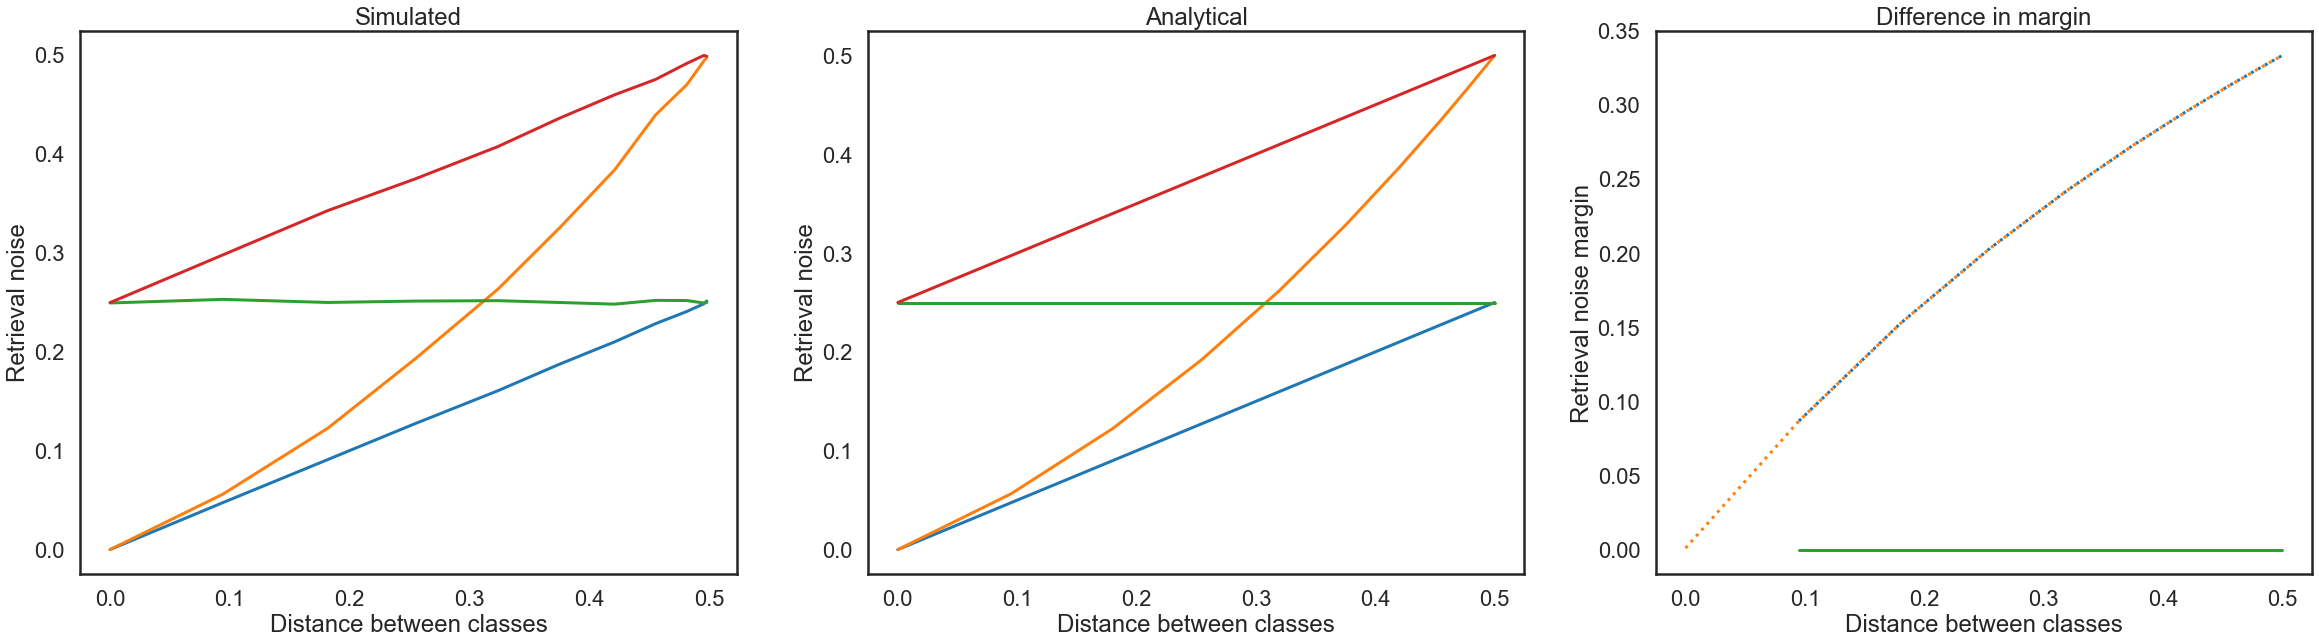

In [5]:
D = 10000
DContext = 5000
NClass = 2

NContext = 3

distances = list(range(0,5500,500))
hDist = np.array(distances)/D

f,ax = plt.subplots(1,3,figsize=(40,10))
x = [run_sim(D,d,DContext,NClass,NContext)[0] for d in distances]
for i in [1,2,4,5]:
    res = [run_sim(D,d,DContext,NClass,NContext)[i] for d in distances]
    ax[0].plot(x,res)
ax[0].set_title('Simulated')
ax[0].set_xlabel('Distance between classes')
ax[0].set_ylabel('Retrieval noise')
    
ax[1].plot([2*d*(1-d) for d in hDist],[get_direct_correct(NContext,d) for d in hDist])
ax[1].plot([2*d*(1-d) for d in hDist],[get_direct_incorrect(NContext,d) for d in hDist])
ax[1].plot([2*d*(1-d) for d in hDist],[get_direct_correct(NContext,d) for d in np.ones(len(hDist))*0.5])
ax[1].plot([2*d*(1-d) for d in hDist],[get_encoded_incorrect(NContext,d) for d in hDist])
ax[1].set_title('Analytical')
ax[1].set_xlabel('Distance between classes')
ax[1].set_ylabel('Retrieval noise')

marginDirect = (np.array([get_direct_incorrect(NContext,d) for d in hDist]) - np.array([get_direct_correct(NContext,d) for d in hDist]))/(np.array([get_direct_incorrect(NContext,d) for d in hDist]) + np.array([get_direct_correct(NContext,d) for d in hDist]))
marginEncoded = (np.array([get_encoded_incorrect(NContext,d) for d in hDist]) - np.array([get_direct_correct(NContext,d) for d in np.ones(len(hDist))*0.5]))/(np.array([get_encoded_incorrect(NContext,d) for d in hDist]) + np.array([get_direct_correct(NContext,d) for d in np.ones(len(hDist))*0.5]))

marginDirect[marginDirect==0] = 1e-3
marginEncoded[marginEncoded==0] = 1e-3

ax[2].plot([2*d*(1-d) for d in hDist],marginDirect,':')
ax[2].plot([2*d*(1-d) for d in hDist],marginEncoded,':')
ax[2].plot([2*d*(1-d) for d in hDist],marginEncoded - marginDirect)
# ax[2].plot([2*d*(1-d) for d in hDist],marginEncoded/marginDirect)
ax[2].set_title('Difference in margin')
ax[2].set_xlabel('Distance between classes')
ax[2].set_ylabel('Retrieval noise margin')
plt.show()

In [6]:
D = 10000
DContext = 5000
NClass = 2

NContext = list(range(1,42,2))
# NContext = [1,3,5]
distances = np.arange(0,5001,250)/D

NFlips = np.round((1 - np.sqrt(1 - 2*distances))/2*D).astype('int')
NIter = 3

# [baseMargin,directCorrect,directIncorrect,directMargin,encodedCorrect,encodedIncorrect,encodedMargin]

baseMargin = np.zeros((len(NContext),len(NFlips)))
distCorrect = np.zeros((len(NContext),len(NFlips)))
distIncorrect = np.zeros((len(NContext),len(NFlips)))
margin = np.zeros((len(NContext),len(NFlips)))
encodedCorrect = np.zeros((len(NContext),len(NFlips)))
encodedIncorrect = np.zeros((len(NContext),len(NFlips)))
encodedMargin = np.zeros((len(NContext),len(NFlips)))

for i,n in enumerate(NContext):
    for j,f in enumerate(NFlips):
        res = np.mean(np.vstack([np.array(run_sim(D,f,DContext,NClass,n)) for _ in range(NIter)]),axis=0)
        distCorrect[i,j] = res[1]
        distIncorrect[i,j] = res[2]
        margin[i,j] = res[3]
        encodedCorrect[i,j] = res[4]
        encodedIncorrect[i,j] = res[5]
        encodedMargin[i,j] = res[6]
        baseMargin[i,j] = res[0]

/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


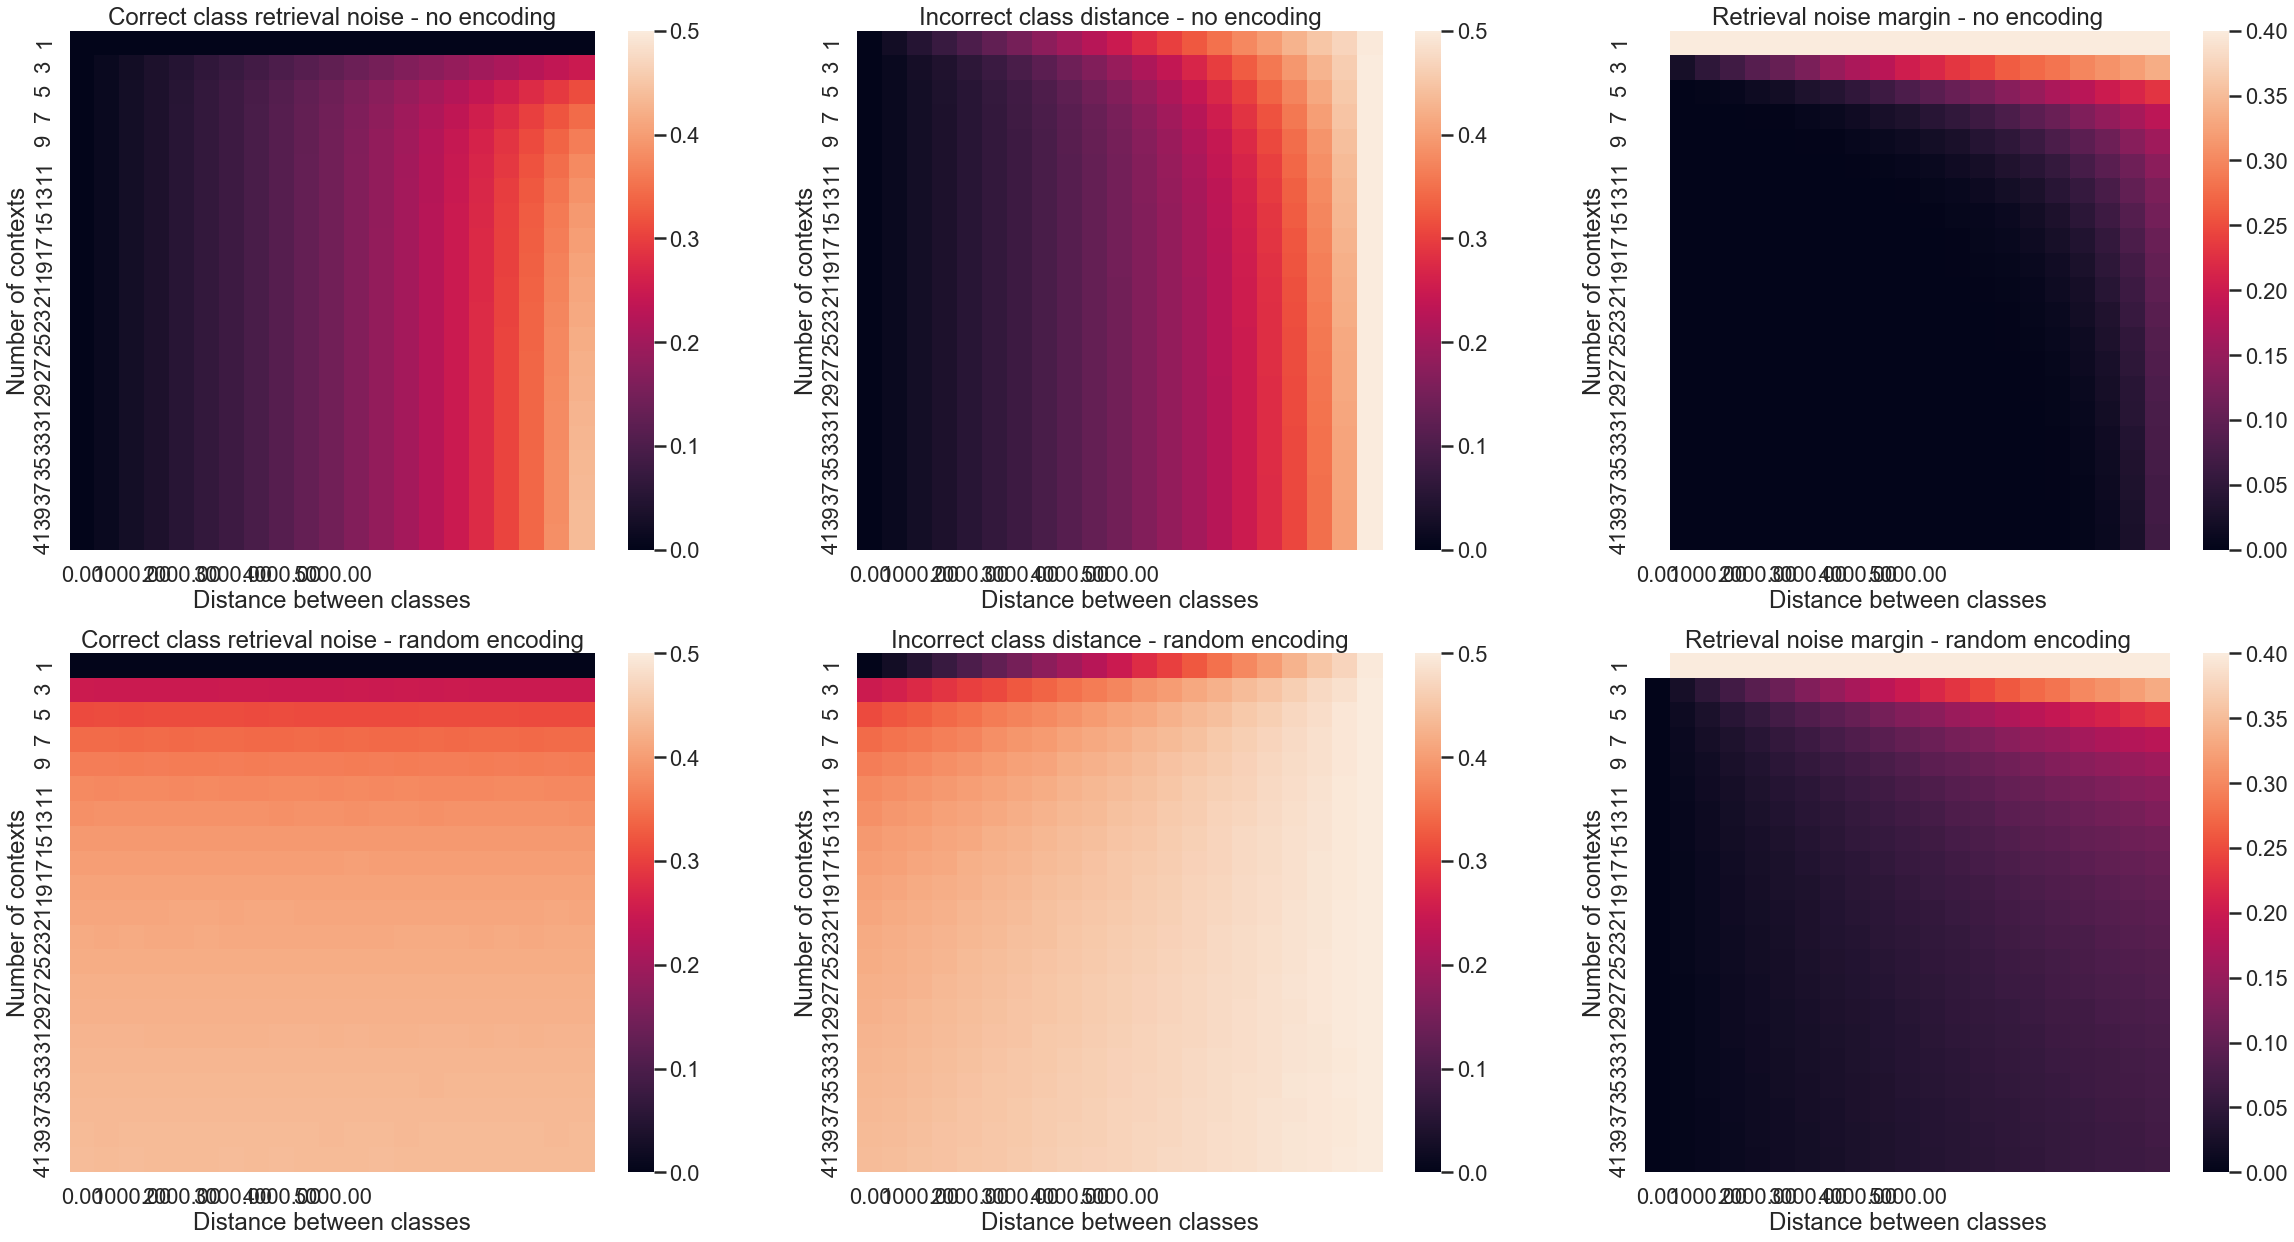

In [9]:
f,ax = plt.subplots(2,3,figsize=(40,21))

sns.heatmap(distCorrect,vmin=0,vmax=0.5,ax=ax[0,0])
ax[0,0].set_xticks(ax[0,0].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[0,0].get_xticks()))
ySpace = np.mean(np.diff(ax[0,0].get_yticks()))
ax[0,0].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[0,0].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[0,0].set_xlabel('Distance between classes')
ax[0,0].set_ylabel('Number of contexts')
ax[0,0].set_title('Correct class retrieval noise - no encoding')

sns.heatmap(distIncorrect,vmin=0,vmax=0.5,ax=ax[0,1])
ax[0,1].set_xticks(ax[0,1].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[0,1].get_xticks()))
ySpace = np.mean(np.diff(ax[0,1].get_yticks()))
ax[0,1].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[0,1].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[0,1].set_xlabel('Distance between classes')
ax[0,1].set_ylabel('Number of contexts')
ax[0,1].set_title('Incorrect class distance - no encoding')

# sns.heatmap((distIncorrect - distCorrect)/(distIncorrect + distCorrect),ax=ax[0,2],vmin=0,vmax=0.3)
sns.heatmap(margin,vmin=0,vmax=0.4,ax=ax[0,2])
ax[0,2].set_xticks(ax[0,2].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[0,2].get_xticks()))
ySpace = np.mean(np.diff(ax[0,2].get_yticks()))
ax[0,2].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[0,2].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[0,2].set_xlabel('Distance between classes')
ax[0,2].set_ylabel('Number of contexts')
ax[0,2].set_title('Retrieval noise margin - no encoding')

sns.heatmap(encodedCorrect,vmin=0,vmax=0.5,ax=ax[1,0])
ax[1,0].set_xticks(ax[1,0].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[1,0].get_xticks()))
ySpace = np.mean(np.diff(ax[1,0].get_yticks()))
ax[1,0].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[1,0].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[1,0].set_xlabel('Distance between classes')
ax[1,0].set_ylabel('Number of contexts')
ax[1,0].set_title('Correct class retrieval noise - random encoding')

sns.heatmap(encodedIncorrect,vmin=0,vmax=0.5,ax=ax[1,1])
ax[1,1].set_xticks(ax[1,1].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[1,1].get_xticks()))
ySpace = np.mean(np.diff(ax[1,1].get_yticks()))
ax[1,1].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[1,1].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[1,1].set_xlabel('Distance between classes')
ax[1,1].set_ylabel('Number of contexts')
ax[1,1].set_title('Incorrect class distance - random encoding')

# sns.heatmap((encodedIncorrect - encodedCorrect)/(encodedIncorrect + encodedCorrect),ax=ax[1,2],vmin=0,vmax=0.3)
sns.heatmap(encodedMargin,vmin=0,vmax=0.4,ax=ax[1,2])
ax[1,2].set_xticks(ax[1,2].get_xticks()[::2])
xSpace = np.mean(np.diff(ax[1,2].get_xticks()))
ySpace = np.mean(np.diff(ax[1,2].get_yticks()))
ax[1,2].set_xticklabels(['%.2f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax[1,2].set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax[1,2].set_xlabel('Distance between classes')
ax[1,2].set_ylabel('Number of contexts')
ax[1,2].set_title('Retrieval noise margin - random encoding')

plt.show()

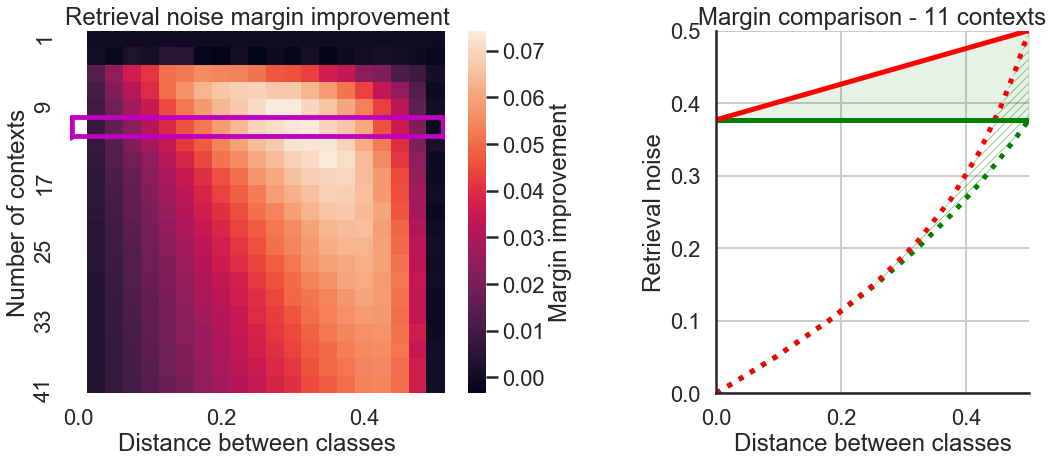

In [28]:
scale = 0.8
f,axes = plt.subplots(1,2,figsize=(20.5*scale,10.3*scale),gridspec_kw={'width_ratios': [3,2]})
ax = axes[0]
distances = np.arange(0,5001,250)/D
sns.heatmap(encodedMargin - margin,ax=ax,cbar_kws={'label': 'Margin improvement'},vmin=np.nanmin(encodedMargin - margin),vmax=np.nanmax(encodedMargin - margin))
ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::2])
xSpace = np.mean(np.diff(ax.get_xticks()))
ySpace = np.mean(np.diff(ax.get_yticks()))
ax.set_xticklabels(['%.1f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax.set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax.set_xlabel('Distance between classes')
ax.set_ylabel('Number of contexts')
ax.set_title('Retrieval noise margin improvement')

x = encodedMargin - margin
ind = np.unravel_index(np.nanargmax(x, axis=None), x.shape)
N = NContext[ind[0]]

rectCol = 'm'
ax.axvline(x=0, ymin=1-ind[0]*0.05-0.04, ymax=1-ind[0]*0.05,color=rectCol,linewidth=12*scale)
ax.axvline(x=21, ymin=1-ind[0]*0.05-0.04, ymax=1-ind[0]*0.05,color=rectCol,linewidth=10*scale)
ax.axhline(y=ind[0],color=rectCol,linewidth=6*scale)
ax.axhline(y=ind[0]+1.1,color=rectCol,linewidth=6*scale)

distances = list(range(0,5500,500))
hDist = np.array(distances)/D

x = np.array([2*d*(1-d) for d in hDist])
dCorrect = np.array([get_direct_correct(N,d) for d in hDist])
dIncorrect = np.array([get_direct_incorrect(N,d) for d in hDist])
eCorrect = np.array([get_direct_correct(N,d) for d in np.ones(len(hDist))*0.5])
eIncorrect = np.array([get_encoded_incorrect(N,d) for d in hDist])

ax = axes[1]

lw = 5
ax.plot(x,dCorrect,'g:',linewidth=lw)
ax.plot(x,dIncorrect,'r:',linewidth=lw)
ax.plot(x,eCorrect,'g',linewidth=lw)
ax.plot(x,eIncorrect,'r',linewidth=lw)

# ax.fill_between(x, dCorrect, dIncorrect, color=None, edgecolor='g', hatch='//', linewidth=0)
ax.fill_between(x, dCorrect, dIncorrect, facecolor="none", hatch="///", edgecolor="g", linewidth=0.0, alpha=0.4)
ax.fill_between(x, eCorrect, eIncorrect, color='g', alpha=0.1)

ax.set_xlim((0,0.5))
ax.set_ylim((0,0.5))
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Margin comparison - %d contexts' % N)
ax.set_xlabel('Distance between classes')
ax.set_ylabel('Retrieval noise')

f.tight_layout(pad=3.0)

plt.show()

In [35]:
temp = (encodedMargin - margin)

In [37]:
temp[1]

array([        nan,  0.00030442, -0.00141853,  0.00284049,  0.00156215,
        0.00518105,  0.00505907, -0.00248263, -0.00286034,  0.00070676,
       -0.00341645, -0.00022521, -0.00240996,  0.00163444, -0.00261968,
       -0.00071658,  0.00087241,  0.00179872,  0.00077087, -0.00021173,
       -0.00171072])